# Data Preprocessing

Il dataset, prima di tutto, va opportunamente elaborato per occuparsi di eventuali dati duplicati o mancanti. Inoltre dovremo separare i dati per ottenere un training e un test set.
Gli step che seguiremo saranno i seguenti:
1. Caricare i dati
2. Gestire i dati mancanti
3. Eliminare le features ridondanti
4. Dividere il dataset in training e test set
5. Normalizzare e standardizzare i dati

## Caricamento dei dati

Tramite `pandas` e il dataset fornito in .csv, carichiamo i dati all'interno di un dataset.

In [141]:
import pandas as pd
import numpy as np

weather_df = pd.read_csv('weather_dataset.csv', sep=',')  # Loading the dataset in a Pandas Dataframe
weather_df

,wind_speed,wind_direction,temperature,dew_point,air_pressure
0,60,260,35,32,10185
1,60,260,36,33,10183
2,60,260,37,34,10181
3,50,260,38,35,10174
4,50,260,39,36,10169
...,...,...,...,...,...
70123,60,250,86,63,10301
70124,50,250,82,65,10299
70125,60,240,82,63,10291
70126,60,250,81,61,10286


## Gestione dei dati mancanti

Con un `for-each` controlliamo, per ogni colonna, quanti sono i valori mancanti.

In [142]:
for column in weather_df.columns:
  number_of_nans_in_column = weather_df[column].isnull().sum()  # Per ogni colonna, somma il numero dei valori che sono null
  print(f"{column} -> {number_of_nans_in_column} missing values")

wind_speed -> 0 missing values
wind_direction -> 0 missing values
temperature -> 0 missing values
dew_point -> 0 missing values
air_pressure -> 0 missing values


Non essendoci valori nulli, procediamo direttamente con la prossima fase.

## Eliminazione di evenutali feature ridondanti

Si mettono in `correlazione` a due a due le feature, e in caso si eliminano feature ridondanti

<AxesSubplot:>

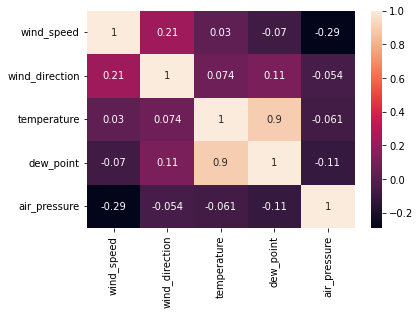

In [143]:
import seaborn as sns

correlations = weather_df.corr() # Calculating the correlations between the columns of the dataset 
sns.heatmap(correlations, annot = True)  # Displaying them in a heatmap

La temperatura e il punto di rugiada hanno una correlazione molto alta, pari a **0.9**.

Questa relazione è attribuibile alla relazione che le due feature hanno: il punto di rugiada è infatti calcolato sulla base della temperatura e dell'umidità relativa in un certo momento.
Visto che dobbiamo fare predizioni sulla temperatura, decidiamo di eliminare la feature "dew_points".

<img width="350" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Dewpoint-RH.svg/800px-Dewpoint-RH.svg.png" 
    alt="grafico_temperatura_rugiada_wikipedia" />

In [144]:
print(list(weather_df.columns))
weather_df = weather_df.drop(columns=['dew_point'])
print(list(weather_df.columns))

['wind_speed', 'wind_direction', 'temperature', 'dew_point', 'air_pressure']
['wind_speed', 'wind_direction', 'temperature', 'air_pressure']


## Divisione del data set in training e test set

Si vuole dividere il data set in 3 parti:
1. Training set, comprendente tutte le righe tranne le ultime 168
2. Test set, comprendente solo le ultime 168 righe

In [145]:
training_set = weather_df[:-168]
test_set = weather_df[-168:]

### VALUTARE SE METTERE O NO PERCHÈ SPEZZA SERIE DI TEMPO -> SECONDO ME NO MA VEDIAMO COSA ESCE FUORI
Per evitare il problema dell'overfitting si vuole dividere il training set in 2 parti a sua volta:
1. Training set, contente l'80% dell'iniziale Training set
2. Validation set, contente il restante 20% dell'iniziale Training set

In [146]:
# from sklearn.model_selection import train_test_split

# training_set, validation_set = train_test_split(training_set, test_size=0.2)

# print(f"The training set is:\n{training_set}\n")
# print(f"The testing set is:\n{validation_set}\n")

## Standardizzazione e normalizzazione dei dati

Per `facilitare la fase di apprendimento` si scalano i dati del dataset.

In [147]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

training_set_scaled = standard_scaler.fit_transform(training_set)
test_set_scaled = standard_scaler.transform(test_set)

print(f"First 10 values in training set before are:\n{training_set.head(10)}\nafter they are:\n{training_set_scaled[:10]}")
print(f"First 10 values in testing set before are:\n{test_set.head(10)}\nafter they are:\n{test_set_scaled[:10]}")

First 10 values in training set before are:
   wind_speed  wind_direction  temperature  air_pressure
0          60             260           35         10185
1          60             260           36         10183
2          60             260           37         10181
3          50             260           38         10174
4          50             260           39         10169
5          60             260           43         10165
6          60             300           44         10171
7          40             290           40         10174
8          40             300           37         10179
9          30             290           40         10181
after they are:
[[ 0.8001791   0.80484909 -0.97017729  0.34613392]
 [ 0.8001791   0.80484909 -0.95547013  0.32548664]
 [ 0.8001791   0.80484909 -0.94076297  0.30483935]
 [ 0.37388489  0.80484909 -0.92605581  0.23257385]
 [ 0.37388489  0.80484909 -0.91134865  0.18095564]
 [ 0.8001791   0.80484909 -0.85252001  0.13966106]
 [ 0.80

**Questa roba qua sotto non so bene come spiegarla ma praticamente divido i due set in "roba che per fittare" e "soluzione di quello che deve predire"**

Quindi ogni 3 righe in train_x ne salvo 1 in train_y, che ipotizzo sia quella da predire
Passo successivo ripeto il procedimento traslando di 1 posizione verso l'ultima posizione l'iteratore.

In [148]:
def split_sequence(sequence, input_size):
    x, y = list(), list()

    for i in range(len(sequence)):
        end_ix = i + input_size
        
        if end_ix > len(sequence)-1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]  # Ogni n_step volte, salva la riga dopo come l'informazione che il modello dovrà predire
        x.append(seq_x)
        y.append(seq_y)

    return x,y

# ogni input_size righe ne predice una
input_size = 3
train_x, train_y = split_sequence(training_set_scaled, input_size)
test_x, test_y = split_sequence(test_set_scaled, input_size)

# codice per fare la trasposta all'evenienza
# print(train_x[:2])
# for i in range(len(train_x)):
#     train_x[i] = train_x[i].transpose()
# print(train_x[:2])
# for i in range(len(train_y)):
#    train_y[i] = train_y[i].transpose()
# for i in range(len(test_x)):
#    test_x[i] = test_x[i].transpose()
# for i in range(len(test_y)):
#    test_y[i] = test_y[i].transpose()

print(f"First 10 values in training set before are:\n{train_x[:10]}\nafter they are:\n{train_y[:10]}")
print(f"First 10 values in testing set before are:\n{test_x[:10]}\nafter they are:\n{test_y[:10]}")

First 10 values in training set before are:
[array([[ 0.8001791 ,  0.80484909, -0.97017729,  0.34613392],
       [ 0.8001791 ,  0.80484909, -0.95547013,  0.32548664],
       [ 0.8001791 ,  0.80484909, -0.94076297,  0.30483935]]), array([[ 0.8001791 ,  0.80484909, -0.95547013,  0.32548664],
       [ 0.8001791 ,  0.80484909, -0.94076297,  0.30483935],
       [ 0.37388489,  0.80484909, -0.92605581,  0.23257385]]), array([[ 0.8001791 ,  0.80484909, -0.94076297,  0.30483935],
       [ 0.37388489,  0.80484909, -0.92605581,  0.23257385],
       [ 0.37388489,  0.80484909, -0.91134865,  0.18095564]]), array([[ 0.37388489,  0.80484909, -0.92605581,  0.23257385],
       [ 0.37388489,  0.80484909, -0.91134865,  0.18095564],
       [ 0.8001791 ,  0.80484909, -0.85252001,  0.13966106]]), array([[ 0.37388489,  0.80484909, -0.91134865,  0.18095564],
       [ 0.8001791 ,  0.80484909, -0.85252001,  0.13966106],
       [ 0.8001791 ,  1.24247071, -0.83781285,  0.20160292]]), array([[ 0.8001791 ,  0.804849

Definiamo il modello di CNN che andremo ad utilizzare.

# Modello con RNN

In [149]:
import torch

batch_size = 6
features = 4
hidden_input_linear = 20

class PrevisionRNN(torch.nn.Module):
    def __init__(self):
        super(PrevisionRNN, self).__init__()
        self.rnn = torch.nn.RNN(input_size = features, hidden_size = hidden_input_linear, num_layers = 2, batch_first = True)
        self.fc = torch.nn.Linear(hidden_input_linear, features)
         
    def forward(self,x): 
        full_out, last_out = self.rnn(x)
        return self.fc(last_out)

In [150]:
import torch

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = PrevisionRNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()
device

device(type='cpu')

In [151]:
import torch
from torch.utils.data import TensorDataset

tensor_ids_train = torch.FloatTensor(train_x)
labels_train = torch.FloatTensor(train_y)
train_dataset = TensorDataset(tensor_ids_train, labels_train)

tensor_ids_test = torch.FloatTensor(test_x)
labels_test = torch.FloatTensor(test_y)
test_dataset = TensorDataset(tensor_ids_test, labels_test)

In [152]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [153]:
train_losses = []
valid_losses = []

def Train():
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().data.numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().cpu().data.numpy())
        print(f'valid_loss {valid_loss}')

In [154]:
epochs = 20

for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()

epochs 1/20


/Users/gianluca/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([6, 4])) that is different to the input size (torch.Size([2, 6, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train_loss 0.8249072432518005
valid_loss 0.5771506428718567
epochs 2/20
train_loss 0.4222222566604614
valid_loss 0.21174496412277222
epochs 3/20
train_loss 0.2650180757045746
valid_loss 0.10009657591581345
epochs 4/20
train_loss 0.2090427279472351
valid_loss 0.07319266349077225
epochs 5/20
train_loss 0.18999674916267395
valid_loss 0.0641341283917427
epochs 6/20
train_loss 0.18022505939006805
valid_loss 0.058829229325056076
epochs 7/20
train_loss 0.172932967543602
valid_loss 0.05498335510492325
epochs 8/20
train_loss 0.16722674667835236
valid_loss 0.05205067992210388
epochs 9/20
train_loss 0.16274259984493256
valid_loss 0.04976828396320343
epochs 10/20
train_loss 0.15918150544166565
valid_loss 0.047948479652404785
epochs 11/20
train_loss 0.15630026161670685
valid_loss 0.04645875468850136
epochs 12/20
train_loss 0.15391765534877777
valid_loss 0.04520998150110245
epochs 13/20
train_loss 0.15190798044204712
valid_loss 0.04414384439587593
epochs 14/20
train_loss 0.15018832683563232
valid_lo

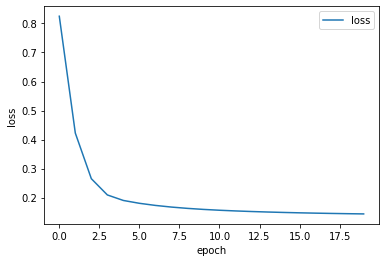

In [155]:
loss_df = pd.DataFrame(train_losses, index=list(range(len(train_losses))), columns=["loss"])

xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")